# Tutorial: Hand gesture classification with EMG data using Riemannian metrics

In this notebook we are using EMG time series collected by 8 electrodes placed on the arm skin. We are going to show how to 
- Process these kind of signal into covariance matrices that we can manipulate with geomstats tools.
- How to apply ML algorithms on this data to classify four different hand gestures present in the data (Rock, Paper, Scissors, Ok).
- How do the different methods (using Riemanian metrics, projecting on tangent space, Euclidean metric) compare to each other.

<img src="figures/paper_rock_scissors.png" />

## Context

The data are acquired from somOS-interface: an sEMG armband that allows you to interact via bluetooth with an Android smartphone (you can contact Marius Guerard (marius.guerard@gmail.com) or Renaud Renault (renaud.armand.renault@gmail.com) for more info on how to make this kind of armband yourself). 

An example of application is to record static signs that are linked with different actions (moving a cursor and clicking, sign recognition for command based personal assistants, ...). In these experiments, we want to evaluate the difference in performance (measured as the accuracy of sign recognition) between three different real life situations where we change the conditions of training (when user record signs or "calibrate" the device) and testing (when the app guess what sign the user is doing):

- 1. What is the accuracy when doing sign recognition right after training?
- 2. What is the accuracy when calibrating, removing and replacing the armband at the same position and then testing? 
- 3. What is the accuracy when calibrating, removing the armband and giving it to someone else that is testing it without calibration?

To simulate these situations, we record data from two different users (rr and mg) and in two different sessions (s1 or s2). The user put the bracelet before every session and remove it after every session.

Quick description of the data:
- Each row corresponds to one acquisition, there is an acquisition every ~4 ms for 8 electrodes which correspond to a 250Hz acquisition rate.
- The time column is in ms.
- The columns c0 to c7 correspond to the electrical value recorded at each of the 8 electrodes (arbitrary unit).
- The label correspond to the sign being recorded by the user at this time point ('rest', 'rock', 'paper', 'scissors', or 'ok). 'rest' correspond to a rested arm.
- the exp identify the user (rr and mg) and the session (s1 or s2)

Note: Another interesting use case, not explored in this notebook, would be to test what is the accruacy when calibrating, removing the armband and giving it to someone else that is calibrating it on its own arm before testing it. The idea being that transfer learning might help getting better results (or faster calibration) than calibrating on one user.

## Setup

Before starting this tutorial, we set the working directory to be the root of the geomstats repository. In order to have the code working on your machine, you need to change this path to the path of your geomstats repository.

In [1]:
import os
import subprocess
import matplotlib
matplotlib.interactive(True)
import matplotlib.pyplot as plt

geomstats_gitroot_path = subprocess.check_output(
    ['git', 'rev-parse', '--show-toplevel'], 
    universal_newlines=True)

os.chdir(geomstats_gitroot_path[:-1])

print('Working directory: ', os.getcwd())

import geomstats.backend as gs

gs.random.seed(2021)

Working directory:  /home/marius/proj/geomstats


INFO: Using numpy backend


## Parameters

In [2]:
N_ELECTRODES = 8
N_SIGNS = 4

## The Data


In [3]:
import geomstats.datasets.utils as data_utils

data = data_utils.load_emg()

In [4]:
data.head()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
0,23,127,123,128,134,125,128,130,124,rest,mg_s1
1,28,126,130,128,119,129,128,126,133,rest,mg_s1
2,32,129,130,127,125,129,129,127,130,rest,mg_s1
3,36,127,128,126,123,128,127,125,131,rest,mg_s1
4,40,127,128,129,124,127,129,127,128,rest,mg_s1


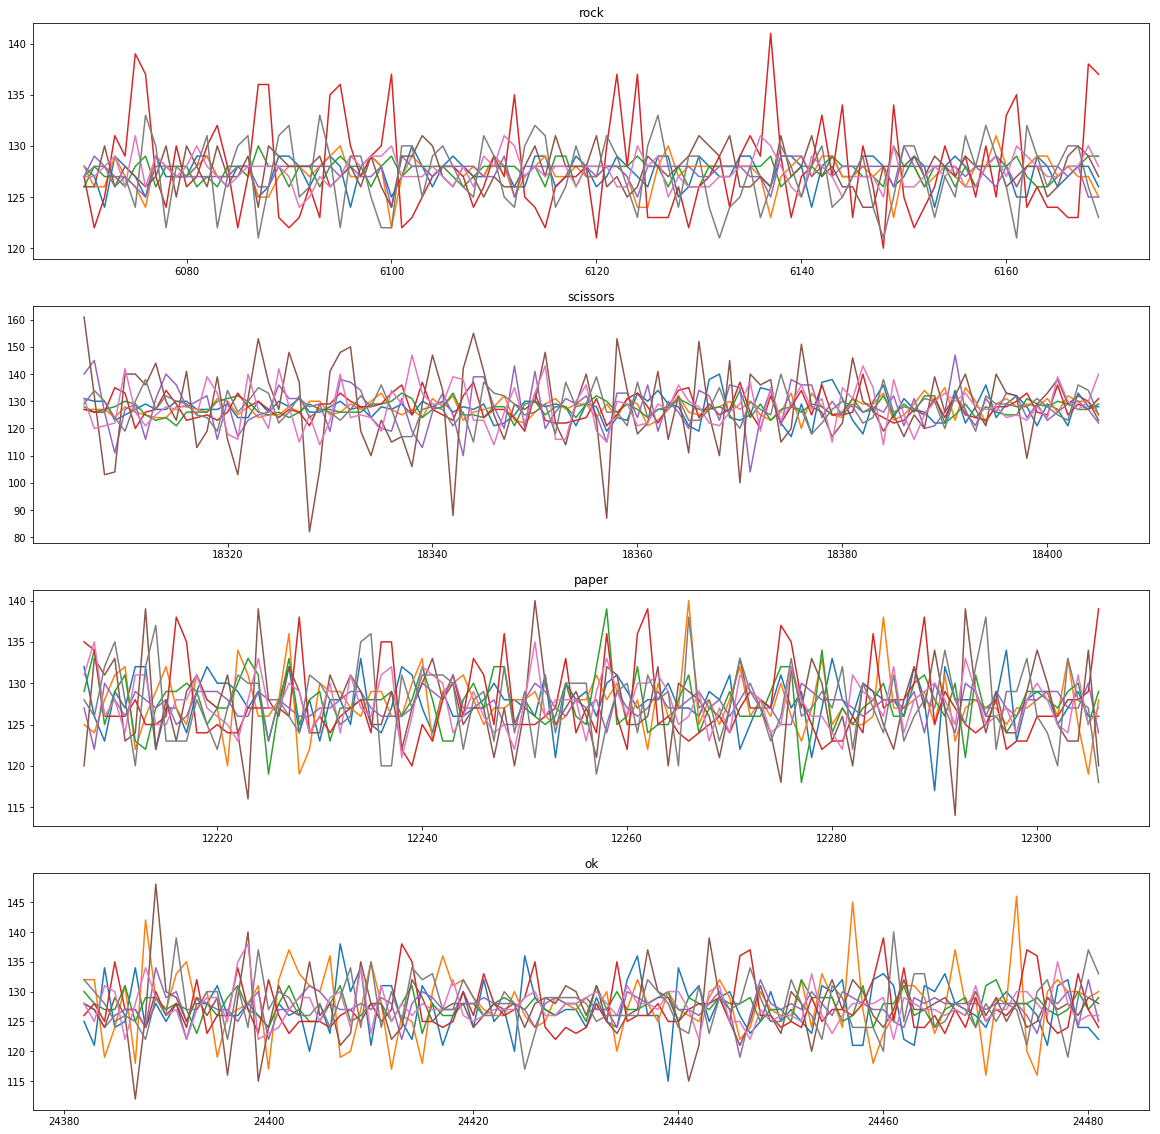

In [5]:
fig, ax = plt.subplots(N_SIGNS, figsize=(20, 20))
label_list = ['rock', 'scissors', 'paper', 'ok']
for i, label_i in enumerate(label_list):
    sign_df = data[data.label==label_i].iloc[:100]
    for electrode in range(N_ELECTRODES):
        ax[i].plot(sign_df.iloc[:, 1 + electrode])
        ax[i].title.set_text(label_i)

We are removing the sign 'rest' for the rest of the analysis.

In [6]:
data = data[data.label != 'rest']

### Preprocessing into covariance matrices

In [7]:
import numpy as np
import pandas as pd

### Parameters.
N_STEPS = 100
LABEL_MAP = {'rock': 0, 'scissors': 1, 'paper': 2, 'ok': 3}
MARGIN = 1000

Unpacking data into arrays for batching

In [8]:
data_dict = {
    'time': gs.array(data.time),
    'raw_data': gs.array(data[['c{}'.format(i) for i in range(N_ELECTRODES)]]),
    'label': gs.array(data.label),
    'exp': gs.array(data.exp)}

In [9]:
from geomstats.datasets.prepare_emg_data import TimeSeriesCovariance

cov_data = TimeSeriesCovariance(data_dict, N_STEPS, N_ELECTRODES, LABEL_MAP, MARGIN)
cov_data.transform()

We check that these matrics belong to the space of SPD matrices.

In [10]:
import geomstats.geometry.spd_matrices as spd

manifold = spd.SPDMatrices(N_ELECTRODES)

In [11]:
gs.all(manifold.belongs(cov_data.covs))

True

#### Covariances plot of the euclidean average

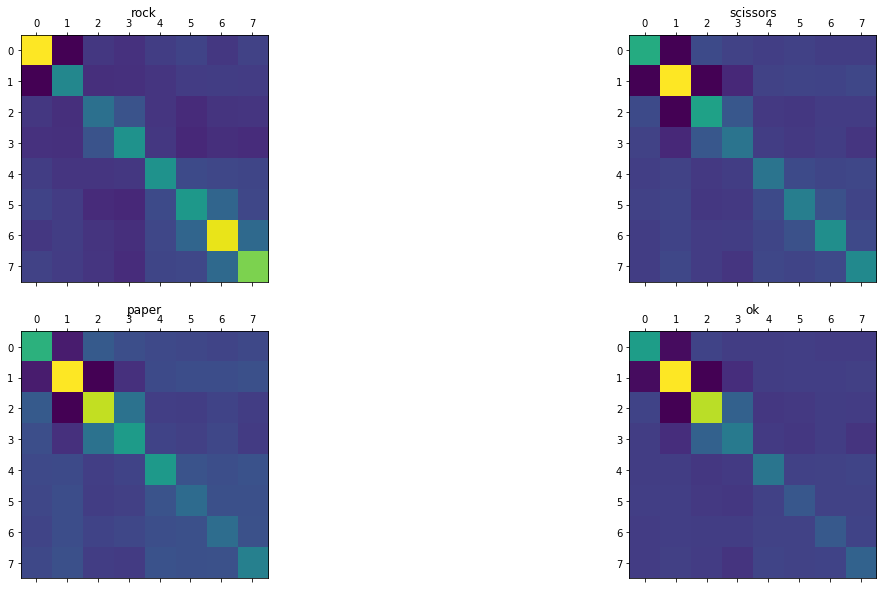

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_cov = np.mean(sign_cov_mat, axis=0)
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

Looking at the euclidean average of the spd matrices for each sign, does not show a striking difference between 3 of our signs (scissors, paper, and ok). Minimum Distance to Mean (MDM) algorithm will probably performed poorly if using euclidean mean here.

#### Covariances plot of the Frechet Mean of the affine invariant metric

In [13]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.spd_matrices import SPDMetricAffine

In [14]:
metric_affine = SPDMetricAffine(N_ELECTRODES)
mean_affine = FrechetMean(metric=metric_affine, point_type='matrix')

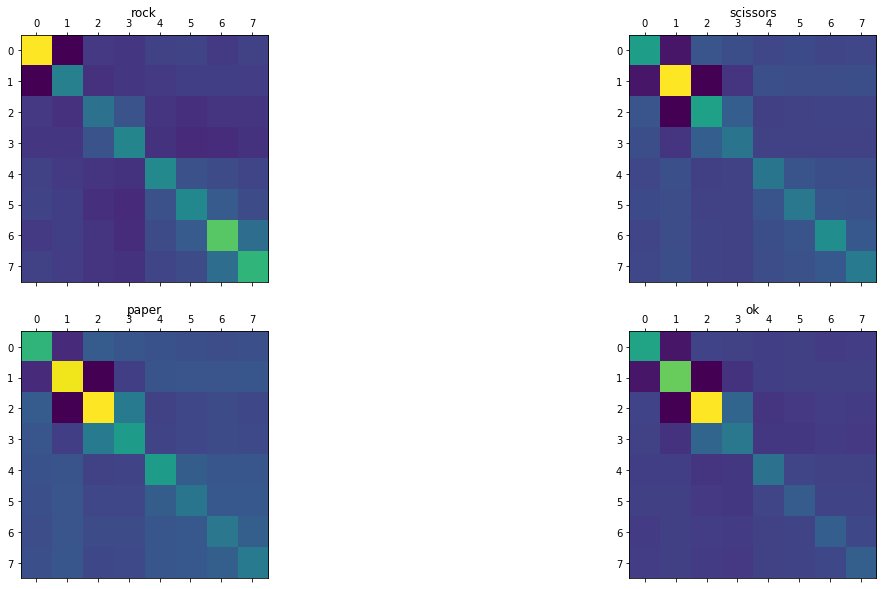

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_affine.fit(X=sign_cov_mat)
    mean_cov = mean_affine.estimate_
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

We see that the average matrices computed using the affine invariant metric are now more differenciated from each other and can potentially give better results, when using MDM to predict the sign linked to a matrix sample.

## Sign Classification

We are now going to train some classifiers on those matrices to see how we can accurately discriminate these 4 hand positions.
The baseline accuracy is defined as the accuracy we get by randomly guessing the signs. In our case, the baseline accuracy is 25%.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [17]:
# Hiding the numerous sklearn warnings
import warnings
warnings.filterwarnings('ignore')

In [44]:
!pip install keras
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 788kB 6.1MB/s eta 0:00:01   35% |███████████▎                    | 276kB 4.1MB/s eta 0:00:01
astroid 2.2.5 requires typed-ast>=1.3.0; implementation_name == "cpython", which is not installed.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0


In [36]:
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

N_EPOCHS is the number of epochs on which to train the DNN. Recommended is ~100

In [18]:
N_EPOCHS = 10
N_FEATURES = int(N_ELECTRODES * (N_ELECTRODES + 1) / 2)

### A. Test on the same session and user as Training/Calibration 

In this first part we are training our model on the same session that we are testing it on. In real life, it corresponds to a user calibrating his armband right before using it. To do this, we are splitting every session in k-folds, training on $(k-1)$ fold to test on the $k^{th}$ last fold. 


In [33]:
class ExpResults:
    """Class handling the score collection and plotting among the different experiments.
    """
    
    def __init__(self, exps):
        self.exps = exps
        self.results = {}
        self.exp_ids = {}
        # Compute the index corresponding to each session only once at initialization.
        for exp in set(self.exps):
            self.exp_ids[exp] = np.where(self.exps==exp)[0]
    
    def add_result(self, model_name, model, X, y):
        """Add the results from the cross validated pipeline.
        
        For the model 'pipeline', it will add the cross validated results of every session in the model_name
        entry of self.results.
        
        Parameters
        ---------- 
        model_name : str
            Name of the pipeline/model that we are adding results from.
        model : sklearn.pipeline.Pipeline
            sklearn pipeline that we are evaluating.
        X : array
            data that we are ingesting in the pipeline.
        y : array
            labels corresponding to the data.
        """
        self.results[model_name] = {'fit_time': [], 'score_time': [], 'test_score': [], 'train_score': []}
        for exp in self.exp_ids.keys():
            ids = self.exp_ids[exp]
            exp_result = cross_validate(pipeline, X[ids], y[ids])
            for key in exp_result.keys():
                self.results[model_name][key] += list(exp_result[key])
        print('Average training score: {}, Average test score: {}'.format(np.mean(self.results[model_name]['train_score']), 
                                                                          np.mean(self.results[model_name]['test_score'])))
        
    def plot_results(self, title, variables, err_bar=None, save_name=None, xlabel='Model', ylabel='Acc'):
        """Plot bar plot comparing the different pipelines' results.
        
        Compare the results added previously using the 'add_result' method with bar plots.
        
        Parameters
        ---------- 
        title : str
            Title of the plot.
        variables : list of array
            List of the variables to plot (e.g. train_score, test_score,...)
        err_bar : list of float
            list of error to use for plotting error bars. If None, std is used by default.
        save_name : str
            path to save the plot. If None, plot is not saved.
        xlabel : str
            Label of the x-axis.
        ylabel : str
            Label of the y-axis.
        """
        ### Some defaults parameters.
        w = 0.5                                                                                                                                                                        
        colors = ['b', 'r', 'gray']
        
        ### Reshaping the results for plotting.
        x_labels = self.results.keys()
        list_vec = []
        for variable in variables:
            list_vec.append(np.array([self.results[model][variable] for model in x_labels]).transpose())
        rand_m1 = lambda size: np.random.random(size) * 2 - 1
        
        ### Plots parameters.                                                                                                                                                                                   
        label_loc = np.arange(len(x_labels))                                                                                                                                            
        center_bar = [w * (i - 0.5) for i in range(len(list_vec))]
        
        ### Plots values.                                                                                                                                                                                       
        avg_vec = [np.nanmean(vec, axis=0) for vec in list_vec]
        if err_bar is None:
            err_bar = [np.nanstd(vec, axis=0) for vec in list_vec]
        
        ### Plotting the data.                                                                                                                                                                                  
        fig, ax = plt.subplots(figsize=(20, 15))
        for i, vec in enumerate(list_vec):
            label_i = variable[i] + ' (n = {})'.format(len(vec))
            rects = ax.bar(label_loc + center_bar[i], avg_vec[i], w, label=label_i,
                           yerr=err_bar[i], color=colors[i], alpha=0.6)
            for j, x in enumerate(label_loc):
                ax.scatter((x + center_bar[i]) + rand_m1(vec[:, j].size) * w/4,
                           vec[:, j], color=colors[i], edgecolor='k')

        # Add some text for labels, title and custom x-axis tick labels, etc.                                                                                                                                   
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(label_loc)
        ax.set_xticklabels(x_labels)
        ax.legend()
        plt.legend()
        
        ### Saving the figure with a timestamp as a name.                                                                                                                                                       
        if save_name is not None:
            plt.savefig(save_name)


In [34]:
exp_arr = data.exp.iloc[cov_data.batches]
intra_sessions_results = ExpResults(exp_arr)

#### A.0. Using Logistic Regression on the vectorized Matrix (Euclidean Method)

In [35]:
pipeline = Pipeline(
    steps=[('standardize', StandardScaler()),
           ('logreg', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])

intra_sessions_results.add_result(model_name='logreg_eucl', model=pipeline, X=cov_data.covecs, y=cov_data.labels)

Average training score: 0.9952095673314819, Average test score: 0.8742901644101732


#### A.1. Using DNN on the vectorized Matrix (Euclidean Method)

In [37]:
def create_model(weights='initial_weights.hd5', n_features=N_FEATURES, n_signs=N_SIGNS):
    """Function to create model, required for using KerasClassifier and wrapp a Keras model inside a 
    scikitlearn form.
    We added a weight saving/loading to remove the randomness of the weight initialization (for better comparison).
    """
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_features, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_signs, activation='softmax'),
])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=N_FEATURES)

Use the line below to generate the 'initial_weights.hd5' file

In [38]:
generate_weights = create_model(weights=None)

In [39]:
pipeline = Pipeline(
    steps=[('standardize', StandardScaler()),
           ('dnn', KerasClassifier(build_fn=create_model, epochs=N_EPOCHS, verbose=0))])

intra_sessions_results.add_result(model_name='dnn_eucl', model=pipeline, X=cov_data.covecs, y=cov_data.labels)

Average training score: 0.9315860768159231, Average test score: 0.7563349033395449


#### A.2. Using Tangent space projection + Logistic Regression

In [40]:
from geomstats.learning.preprocessing import ToTangentSpace

pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric_affine)),
           ('standardize', StandardScaler()),
           ('logreg', LogisticRegression(solver='lbfgs', multi_class='multinomial'))])

intra_sessions_results.add_result(model_name='logreg_affinvariant_tangent', model=pipeline, X=cov_data.covs, y=cov_data.labels)

Average training score: 0.9979362910724271, Average test score: 0.8770538577108459


#### A.3. Using Tangent space projection + DNN

In [41]:
pipeline = Pipeline(
    steps=[('feature_ext', ToTangentSpace(geometry=metric_affine)),
           ('standardize', StandardScaler()),
           ('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=N_EPOCHS, verbose=0))])

intra_sessions_results.add_result(model_name='dnn_affinvariant_tangent', model=pipeline, X=cov_data.covs, y=cov_data.labels)

Average training score: 0.94588303565979, Average test score: 0.7830353255073229


#### A.4. Using Euclidean MDM

#### A.5. Using MDM with a Riemannian metric

#### Summary plots

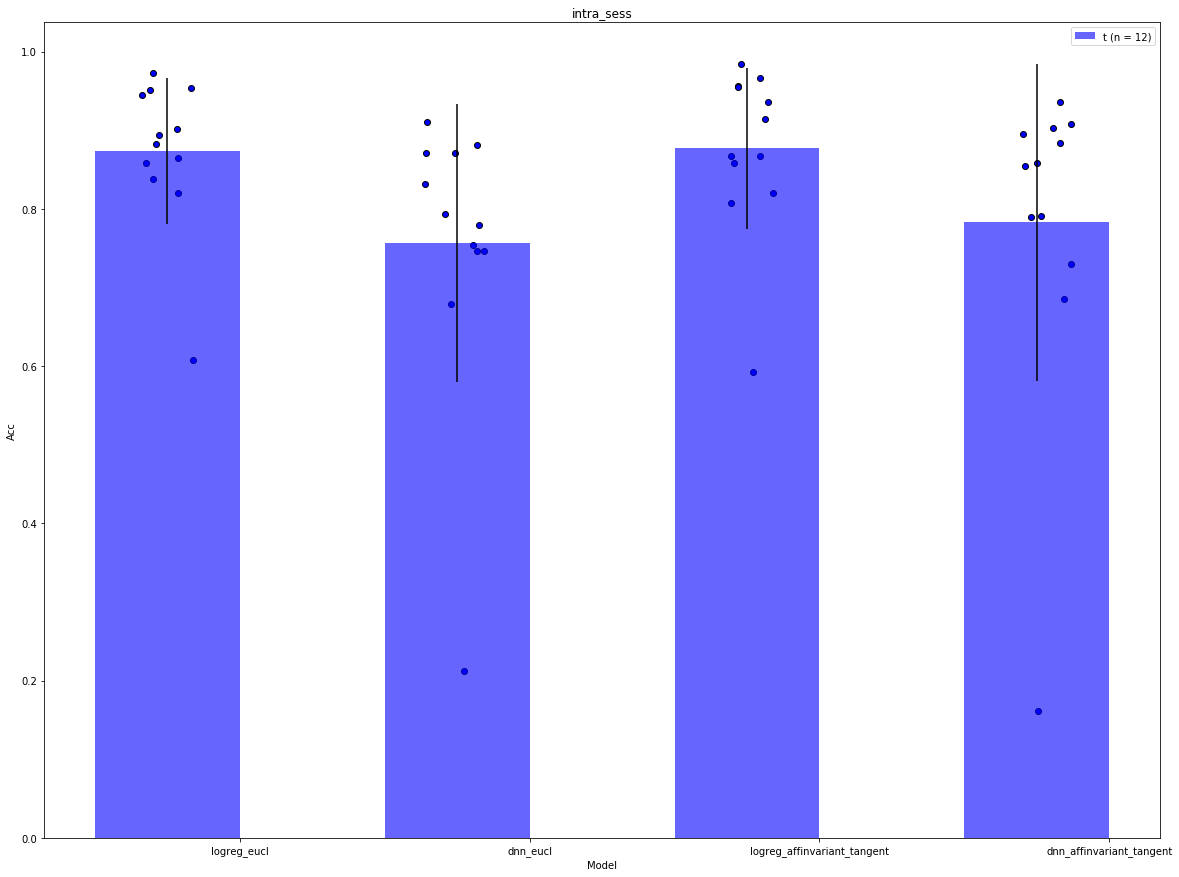

In [42]:
intra_sessions_results.plot_results('intra_sess', ['test_score'])